In [18]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
# dealing with images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

In [19]:
metadata = pd.read_csv("/datasets/nicolas_facchinetti/img_data/emodb_df.csv")
metadata.head()

,Path,Label,Actor
0,/datasets/nicolas_facchinetti/img_data/emodb/0...,sad,13
1,/datasets/nicolas_facchinetti/img_data/emodb/1...,sad,13
2,/datasets/nicolas_facchinetti/img_data/emodb/2...,sad,13
3,/datasets/nicolas_facchinetti/img_data/emodb/3...,sad,13
4,/datasets/nicolas_facchinetti/img_data/emodb/4...,sad,13


In [20]:
def leave_one_speaker_out(data, n=5):
    speakers = data.Actor.unique()
    # random select n actors as test
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        # take all but not actor i data
        trainIndices = data[~(data['Actor']==i)].index.values.astype(int)
        # take only original samples
        testIndices =  data[(data['Actor']==i)].index.values.astype(int)
        
        np.random.shuffle(trainIndices)
        np.random.shuffle(testIndices)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [21]:
kf = leave_one_speaker_out(metadata, n=3)         

In [22]:
kf

[(array([2298, 4172, 1449, ..., 2219, 4251, 2697]),
  array([5867, 4994,   13, 2573, 1684, 4040, 5189, 4754,  489, 5696, 5182,
         1109, 5763, 5353, 5364,  492, 5558, 4747, 3834, 5754, 1425, 3900,
         1238, 1113,   11, 4045, 2556, 5760, 4877, 1415, 3313, 1236, 4243,
         1179, 5864, 1230, 4300, 5692, 5148, 4988, 1088,   67, 5073, 4150,
         5560,    8, 1705, 2564, 4348, 3153, 1413, 4878, 2144,    0, 3310,
         3729, 1691, 5224, 1087, 5871, 5415, 1420, 1180,  488, 1745, 3149,
           63, 3847, 4991, 1421, 5151, 1428, 4246, 5221, 1740, 3623, 5640,
           68,  213, 2150, 4272,   17, 5751,    6, 4145, 1712, 5188, 1424,
          503, 3726, 5691, 4989, 1224, 3601, 5874, 1549, 1885, 4242, 5759,
         4363, 5217, 3736, 2830, 5412, 1550, 1951, 3893,  218, 1229, 4364,
         3273, 5365, 3841, 5069, 4992, 5411, 1952, 1409, 4268, 1228, 3691,
         3727, 3177, 2543, 1083, 1085, 5651, 1184, 3838, 4350, 2540, 5762,
         2560, 5753, 5564, 5068, 3735, 5075, 359

In [23]:
kf[0][0]

array([2298, 4172, 1449, ..., 2219, 4251, 2697])

In [24]:
metadata.iloc[kf[0][0]]

,Path,Label,Actor
2298,/datasets/nicolas_facchinetti/img_data/emodb/2...,bored,9
4172,/datasets/nicolas_facchinetti/img_data/emodb/4...,angry,3
1449,/datasets/nicolas_facchinetti/img_data/emodb/1...,angry,16
3633,/datasets/nicolas_facchinetti/img_data/emodb/3...,fear,14
1912,/datasets/nicolas_facchinetti/img_data/emodb/1...,bored,10
...,...,...,...
1254,/datasets/nicolas_facchinetti/img_data/emodb/1...,neutral,15
3392,/datasets/nicolas_facchinetti/img_data/emodb/3...,fear,10
2219,/datasets/nicolas_facchinetti/img_data/emodb/2...,sad,11
4251,/datasets/nicolas_facchinetti/img_data/emodb/4...,disgust,9


In [25]:
metadata.iloc[kf[0][1]]

,Path,Label,Actor
5867,/datasets/nicolas_facchinetti/img_data/emodb/5...,angry,13
4994,/datasets/nicolas_facchinetti/img_data/emodb/4...,angry,13
13,/datasets/nicolas_facchinetti/img_data/emodb/1...,sad,13
2573,/datasets/nicolas_facchinetti/img_data/emodb/2...,bored,13
1684,/datasets/nicolas_facchinetti/img_data/emodb/1...,bored,13
...,...,...,...
5404,/datasets/nicolas_facchinetti/img_data/emodb/5...,angry,13
4367,/datasets/nicolas_facchinetti/img_data/emodb/4...,neutral,13
2826,/datasets/nicolas_facchinetti/img_data/emodb/2...,happy,13
5417,/datasets/nicolas_facchinetti/img_data/emodb/5...,happy,13


In [26]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [27]:
path_dir = "./"
bs = 64
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [28]:
def train_evaluate(model_fn, train, val, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    # fit & predict
    history = m.fit(train,
                    epochs=30,
                    validation_data=val,
                    workers=16,
                    verbose=1)
    print("Done")
    return history

In [29]:
cat = metadata["Label"].unique()
cat

array(['sad', 'fear', 'neutral', 'happy', 'bored', 'angry', 'disgust'],
      dtype=object)

In [30]:
def train_kfold(kf, metadata, model_fn):
    results = []
    for train_index, val_index in kf:
        train_df = metadata.iloc[train_index]
        test_df = metadata.iloc[val_index]

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=path_dir,
            x_col="Path",
            y_col="Label",
            batch_size=bs,
            shuffle=True,
            target_size=(256, 256),
            class_mode='categorical'
        )

        test_generator=test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=path_dir,
            x_col="Path",
            y_col="Label",
            batch_size=bs,
            shuffle=False,
            class_mode="categorical",
            target_size=(256, 256))

        results.append(train_evaluate(model_fn, train_generator, test_generator))
    return results

# Models

In [40]:
def get_m12():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Conv2D(16, kernel_size=(11,11), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(4,4), strides=2),

            Conv2D(32, kernel_size=(9,9), activation='relu'),
            MaxPooling2D(pool_size=(4,4), strides=2),

            Conv2D(64, kernel_size=(7,7), activation='relu'),
            MaxPooling2D(pool_size=(4,4), strides=1),
        
            Conv2D(128, kernel_size=(5,5), activation='relu'),
            MaxPooling2D(pool_size=(4,4), strides=1),
            Flatten(),
            Dense(7, activation='softmax')
    ])
    return m

get_m12().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 246, 246, 16)      5824      
_________________________________________________________________
batch_normalization_14 (Batc (None, 246, 246, 16)      64        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 122, 122, 16)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 114, 114, 32)      41504     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 64)        100416    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 47, 47, 64)      

In [41]:
t1 = train_kfold(kf, metadata, get_m12)

Found 5509 validated image filenames belonging to 7 classes.
Found 673 validated image filenames belonging to 7 classes.
Epoch 1/30
87/87 [==============================] - 12s 124ms/step - loss: 8.9036 - accuracy: 0.3347 - val_loss: 1.8298 - val_accuracy: 0.2511
Epoch 2/30
87/87 [==============================] - 11s 124ms/step - loss: 1.1542 - accuracy: 0.5657 - val_loss: 1.6403 - val_accuracy: 0.4413
Epoch 3/30
87/87 [==============================] - 11s 119ms/step - loss: 0.9945 - accuracy: 0.6505 - val_loss: 1.4882 - val_accuracy: 0.4012
Epoch 4/30
87/87 [==============================] - 11s 117ms/step - loss: 0.8317 - accuracy: 0.7075 - val_loss: 1.4196 - val_accuracy: 0.4160
Epoch 5/30
87/87 [==============================] - 11s 123ms/step - loss: 0.7536 - accuracy: 0.7329 - val_loss: 1.6057 - val_accuracy: 0.4131
Epoch 6/30
87/87 [==============================] - 11s 119ms/step - loss: 0.6657 - accuracy: 0.7643 - val_loss: 1.2607 - val_accuracy: 0.5111
Epoch 7/30
87/87 [===

91/91 [==============================] - 11s 111ms/step - loss: 0.2274 - accuracy: 0.9268 - val_loss: 4.4095 - val_accuracy: 0.4816
Epoch 27/30
91/91 [==============================] - 11s 111ms/step - loss: 0.1277 - accuracy: 0.9545 - val_loss: 6.0262 - val_accuracy: 0.4275
Epoch 28/30
91/91 [==============================] - 11s 111ms/step - loss: 0.1017 - accuracy: 0.9687 - val_loss: 5.1186 - val_accuracy: 0.4865
Epoch 29/30
91/91 [==============================] - 10s 109ms/step - loss: 0.1051 - accuracy: 0.9645 - val_loss: 6.5976 - val_accuracy: 0.4472
Epoch 30/30
91/91 [==============================] - 11s 114ms/step - loss: 0.1151 - accuracy: 0.9647 - val_loss: 4.5365 - val_accuracy: 0.5307
Done
Found 5306 validated image filenames belonging to 7 classes.
Found 876 validated image filenames belonging to 7 classes.
Epoch 1/30
83/83 [==============================] - 12s 135ms/step - loss: 6.0504 - accuracy: 0.2922 - val_loss: 2.9603 - val_accuracy: 0.1644
Epoch 2/30
83/83 [=====

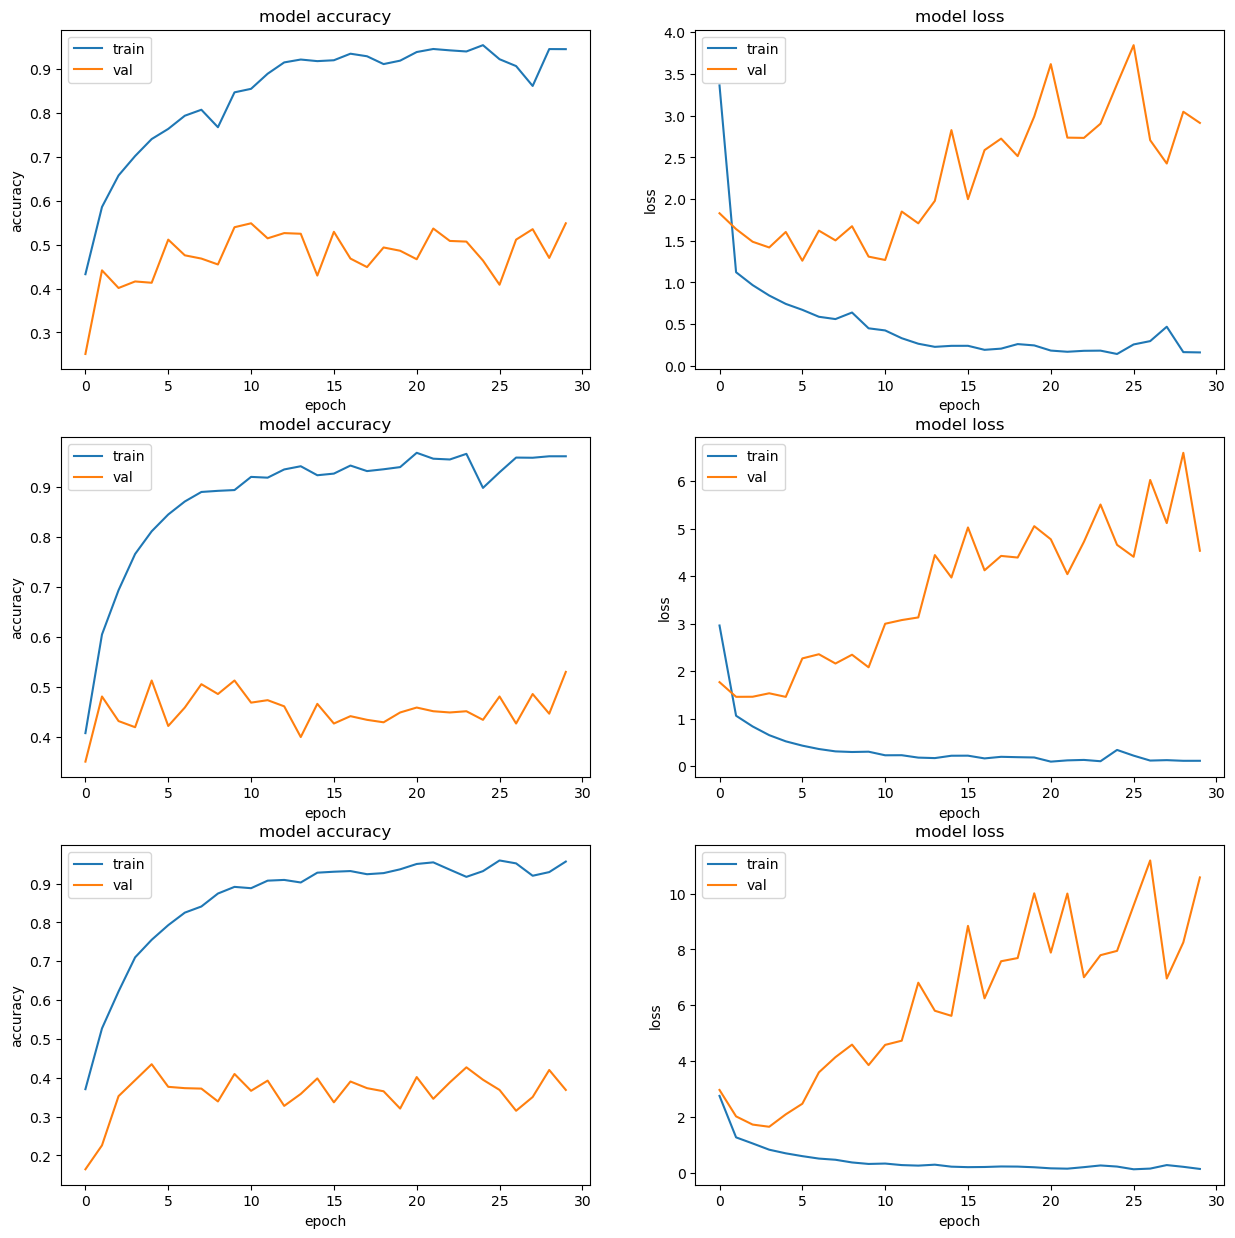

In [42]:
plot_stats(t1)